In [ ]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

import healpy as hp
import cartopy.feature as cfeature
import cartopy.crs as ccrs

from cartopy.io import shapereader
from shapely.geometry import Point
from haversine import haversine_vector, Unit


In [ ]:
# dtypes = {
#     'ID':'int32',
#     'time':'int32',
#     'latitude':'float32',
#     'longitude':'float32',
#     'lon360':'float32',
#     'sst':'float32',
#     'err_sst':'float32',
#     've':'float32',
#     'vn':'float32',
#     'err_lat':'float32',
#     'err_lon':'float32',
# }

date_cols = ['time']


df = pd.read_csv("drifter_6hour_qc_723d_ea19_204a.csv",
                #  dtype=dtypes,
                 parse_dates=date_cols,
                 skiprows=[1])

In [ ]:
len(df.ID.unique())

In [ ]:
df.dtypes

In [ ]:
if False:
    # Step 1: Create the figure and ax with a geographic projection
    fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={'projection': ccrs.PlateCarree()})

    # Step 2: Add a basic world map
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    # Optional: gridlines
    ax.gridlines(draw_labels=True)

    # Step 3: Set the extent (optional - to zoom into a specific region)
    # ax.set_extent([-180, 180, -90, 90])  # global view

    # Step 4: Plot your data (replace these with your actual data)
    for unique_id in tqdm(df.ID.unique()[0::1]):
        slice_df = df[df.ID == unique_id][["latitude", "longitude"]].astype(float)
        longitudes = slice_df['longitude'].to_numpy()
        latitudes = slice_df['latitude'].to_numpy()
        
        jumps = np.abs(np.diff(longitudes))
        split_indices = np.where(jumps > 180)[0] + 1
        
        lon_segments = np.split(longitudes, split_indices)
        lat_segments = np.split(latitudes, split_indices)

        for idx, lon_segment in enumerate(lon_segments):
            ax.plot(lon_segment, lat_segments[idx], transform=ccrs.PlateCarree(), color=(20/256, 148/256, 219/256,0.05))  # 'ro' for red dots

        # ax = df[df.ID == unique_id][["latitude", "longitude"]].plot(ax=ax, y="latitude", x = "longitude", legend=False)


    plt.savefig("Drifter Plot.png")


In [ ]:
df_slice = df.loc[::1000]

longitudes = torch.from_numpy(df_slice.longitude.values)
latitudes = torch.from_numpy(df_slice.latitude.values)
north_velocities = torch.from_numpy(df_slice.vn.values)
east_velocities = torch.from_numpy(df_slice.ve.values)
ssts = torch.from_numpy(df_slice.sst.values)

In [ ]:
# 1. Creating a world grid

# healpy is designed to provide pixelated data on a sphere. It will help us pixelate the earth into a discretised grid which we can then do our approximations on.

nside = 64  # Set the resolutio of the grid. (Given by power of 2)
npix = hp.nside2npix(nside) #Returns optimum number of pixels required

theta, phi = hp.pix2ang(nside, np.arange(npix)) # Returns the centre of a discretised grid of points for the specified number of pixels

grid_latitudes = torch.from_numpy(np.degrees(0.5 * np.pi - theta)) # Convert centre into latitude and longitude measurements
grid_longitudes = torch.from_numpy(180 - np.degrees(phi))

land_shpfilename = shapereader.natural_earth(resolution='110m',
                                              category='physical',
                                              name='land') # Get land polygons from Natural Earth data
land_geoms = list(shapereader.Reader(land_shpfilename).geometries())



ocean_values = np.ones(npix, dtype=np.uint8) # Mask to set oceans. 0 for land

for i in range(npix):
    point = Point(grid_longitudes[i], grid_latitudes[i])
    if any(geom.contains(point) for geom in land_geoms):
        ocean_values[i] = 0  # land


v_velocity = np.zeros(npix, dtype=np.float32) # Ocean data matrix initialised to 0.
u_velocity = np.zeros(npix, dtype=np.float32) # Ocean data matrix initialised to 0.
sst_interpolate = np.zeros(npix, dtype=np.float32) # Ocean data matrix initialised to 0.

hp.mollview(ocean_values, title="Pixelated earth", cmap='coolwarm') # mollview is a special function that assumes the correct length of the mask variable.
plt.show()


In [ ]:
def geodesic_distance_torch(ref_lat, ref_lon, batch_lat, batch_lon, radius=6371.0):
    """
    Approximate geodesic distance on Earth using Haversine formula.
    Inputs:
      - ref_lat, ref_lon: scalars (reference point) in degrees or tensors broadcastable to batch_lat/batch_lon
      - batch_lat, batch_lon: tensors of points in degrees
    Returns:
      - distances tensor (in kilometers)
    """
    # convert degrees to radians
    ref_lat = torch.deg2rad(ref_lat)
    ref_lon = torch.deg2rad(ref_lon)
    batch_lat = torch.deg2rad(batch_lat)
    batch_lon = torch.deg2rad(batch_lon)

    dlat = batch_lat - ref_lat
    dlon = batch_lon - ref_lon

    a = torch.sin(dlat / 2) ** 2 + torch.cos(ref_lat) * torch.cos(batch_lat) * torch.sin(dlon / 2) ** 2
    c = 2 * torch.atan2(torch.sqrt(a), torch.sqrt(1 - a))

    return radius * c

In [ ]:
# 2. Loop over each point in the grid
# If the grid is land ignore.
# If the grid is water, fetch floaters that are within a certain distance of the point.
# Perform a gaussian smoothing on them to guess the velocity



b = 1000

for idx, u_idx in tqdm(enumerate(v_velocity)):
    if ocean_values[idx]==1:
      this_lat = grid_latitudes[idx]
      this_lon = grid_longitudes[idx]
      

      distances = geodesic_distance_torch(this_lat, this_lon, latitudes, longitudes)
      kernel_weights = torch.exp(-distances**2 / (2 * b**2))
      kernel_weights[north_velocities==-999999.0] = 0 # Missing data catch. Missing entries are encoded as -999999.0
      kernel_weights[torch.isnan(kernel_weights)] = 0
      
      v_velocity[idx] = (north_velocities * kernel_weights).sum() / kernel_weights.sum()
      u_velocity[idx] = (east_velocities * kernel_weights).sum() / kernel_weights.sum()
      sst_interpolate[idx] = (ssts * kernel_weights).nansum() / kernel_weights.sum()


In [ ]:

mask = (ocean_values == 1)

lat_ocean = grid_latitudes[mask]
lon_ocean = grid_longitudes[mask]
X_ocean = v_velocity[mask]


# Step 1: Create the figure and ax with a geographic projection
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Step 2: Add a basic world map
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Optional: gridlines
ax.gridlines(draw_labels=True)
sc = ax.scatter(lon_ocean, lat_ocean, c=X_ocean, cmap='viridis', marker='o', s=10)
plt.colorbar(sc, label='North velocity')


# plt.savefig("Northvelocity_gaussiansmooth_b1000.png")


In [ ]:

mask = (ocean_values == 1)

lat_ocean = grid_latitudes[mask]
lon_ocean = grid_longitudes[mask]
X_ocean = u_velocity[mask]


# Step 1: Create the figure and ax with a geographic projection
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Step 2: Add a basic world map
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Optional: gridlines
ax.gridlines(draw_labels=True)
sc = ax.scatter(lon_ocean, lat_ocean, c=X_ocean, cmap='viridis', marker='o', s=10)
plt.colorbar(sc, label='East velocity')


# plt.savefig("Eastvelocity_gaussiansmooth_b1000.png")


In [ ]:
mask = (ocean_values == 1)

lat_ocean = grid_latitudes[mask]
lon_ocean = grid_longitudes[mask]
X_ocean = sst_interpolate[mask]


# Step 1: Create the figure and ax with a geographic projection
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Step 2: Add a basic world map
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Optional: gridlines
ax.gridlines(draw_labels=True)
sc = ax.scatter(lon_ocean, lat_ocean, c=X_ocean, cmap='viridis', marker='o', s=10)
plt.colorbar(sc, label='Temperature')


plt.savefig("sst_gaussiansmooth_b1000.png")


In [ ]:
times = df.loc[df.sst.notna(),'time']
temperatures = df.loc[df.sst.notna(), "sst"]

In [ ]:
timestamps = times.apply(lambda x: x.timestamp())

In [ ]:
corr = np.corrcoef(timestamps, temperatures)[0,1]
m = np.std(temperatures)*corr/np.std(timestamps)
b = np.mean(temperatures) - m*np.mean(timestamps)




In [ ]:
fig, ax = plt.subplots(figsize=(20,10))

ax.scatter(times[::100],temperatures[::100], s=0.1, alpha=0.2)
ax.plot([times.min(), times.max()], [m*timestamps.min()+b, m*timestamps.max()+b], 'r', label='Naive Linear')
plt.show()


In [ ]:
df_equatorial = df[( (df.latitude < 30) & (df.latitude > -30) ) & (df.time > pd.Timestamp("2020-01-01", tz='UTC'))]

In [ ]:
times = df_equatorial.loc[df_equatorial.sst.notna(),'time']
temperatures = df_equatorial.loc[df_equatorial.sst.notna(), "sst"]
timestamps = times.apply(lambda x: x.timestamp())
corr = np.corrcoef(timestamps, temperatures)[0,1]
m = np.std(temperatures)*corr/np.std(timestamps)
b = np.mean(temperatures) - m*np.mean(timestamps)


fig, ax = plt.subplots(figsize=(20,10))

ax.scatter(times[::100],temperatures[::100], s=0.1, alpha=0.7)
ax.plot([times.min(), times.max()], [m*timestamps.min()+b, m*timestamps.max()+b], 'r', label='Naive Linear')
ax.set_title("Equatorial temperatures overtime")
plt.show()


In [ ]:
m * 60*60*24*365.25

In [ ]:
dts_intervals = pd.to_datetime(np.linspace(df.time.min().timestamp(),df.time.max().timestamp(),10), unit='s').tz_localize('UTC').to_series()

In [ ]:
dts_intervals.iloc[0] = dts_intervals.iloc[0] - pd.Timedelta(days=1)

In [ ]:
dts_intervals

In [ ]:
dts_intervals[3]

In [ ]:
for idx, dt_val in tqdm(enumerate(dts_intervals)):
    if idx==0:
        continue

    dt_val = dts_intervals.iloc[idx]

    dt_prev = dts_intervals.iloc[idx-1]

    df_slice = df.loc[(df.time >= dt_prev) & (df.time <= dt_val)]
    df_slice = df_slice.iloc[::100]

    longitudes = torch.from_numpy(df_slice.longitude.values)
    latitudes = torch.from_numpy(df_slice.latitude.values)
    north_velocities = torch.from_numpy(df_slice.vn.values)
    east_velocities = torch.from_numpy(df_slice.ve.values)
    ssts = torch.from_numpy(df_slice.sst.values)


    # 1. Creating a world grid

    # healpy is designed to provide pixelated data on a sphere. It will help us pixelate the earth into a discretised grid which we can then do our approximations on.

    nside = 64  # Set the resolutio of the grid. (Given by power of 2)
    npix = hp.nside2npix(nside) #Returns optimum number of pixels required

    theta, phi = hp.pix2ang(nside, np.arange(npix)) # Returns the centre of a discretised grid of points for the specified number of pixels

    grid_latitudes = torch.from_numpy(np.degrees(0.5 * np.pi - theta)) # Convert centre into latitude and longitude measurements
    grid_longitudes = torch.from_numpy(180 - np.degrees(phi))

    land_shpfilename = shapereader.natural_earth(resolution='110m',
                                                category='physical',
                                                name='land') # Get land polygons from Natural Earth data
    land_geoms = list(shapereader.Reader(land_shpfilename).geometries())



    ocean_values = np.ones(npix, dtype=np.uint8) # Mask to set oceans. 0 for land

    for i in range(npix):
        point = Point(grid_longitudes[i], grid_latitudes[i])
        if any(geom.contains(point) for geom in land_geoms):
            ocean_values[i] = 0  # land


    v_velocity = np.zeros(npix, dtype=np.float32) # Ocean data matrix initialised to 0.
    u_velocity = np.zeros(npix, dtype=np.float32) # Ocean data matrix initialised to 0.
    sst_interpolate = np.zeros(npix, dtype=np.float32) # Ocean data matrix initialised to 0.

    # hp.mollview(ocean_values, title="Pixelated earth", cmap='coolwarm') # mollview is a special function that assumes the correct length of the mask variable.
    # plt.show()



    b = 1000

    for idx, u_idx in tqdm(enumerate(v_velocity)):
        if ocean_values[idx]==1:
            this_lat = grid_latitudes[idx]
            this_lon = grid_longitudes[idx]
        

            distances = geodesic_distance_torch(this_lat, this_lon, latitudes, longitudes)
            kernel_weights = torch.exp(-distances**2 / (2 * b**2))
            kernel_weights[north_velocities==-999999.0] = 0 # Missing data catch. Missing entries are encoded as -999999.0
            kernel_weights[torch.isnan(kernel_weights)] = 0
            
            v_velocity[idx] = (north_velocities * kernel_weights).sum() / kernel_weights.sum()
            u_velocity[idx] = (east_velocities * kernel_weights).sum() / kernel_weights.sum()
            sst_interpolate[idx] = (ssts * kernel_weights).nansum() / kernel_weights.sum()

    pd.DataFrame(
        {
            "NorthVelocity":v_velocity, 
            "EastVelocity":u_velocity,
            "Temperature":sst_interpolate
        }).to_csv(f"{dt_prev.year}_{dt_val.year}_GaussianSmoothedb1000.csv",index=False)

In [ ]:
(grid_latitudes.unique()[1:] - grid_latitudes.unique()[:-1]).mean()

In [ ]:
(grid_longitudes.unique()[1:] - grid_longitudes.unique()[:-1]).mean()

In [ ]:
geodesic_distance_torch(torch.tensor(0),torch.tensor(0),torch.tensor(0.7029),torch.tensor(0))

In [ ]:
geodesic_distance_torch(torch.tensor(0),torch.tensor(0),torch.tensor(0),torch.tensor(0.0507))

In [ ]:
year0, year1, _ =  [i for i in os.listdir() if "1000.csv" in i][0].split("_")


In [85]:

# mask = (ocean_values == 1)

# lat_ocean = grid_latitudes[mask]
# lon_ocean = grid_longitudes[mask]
# X_ocean = u_velocity[mask]


# # Step 1: Create the figure and ax with a geographic projection
# fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# # Step 2: Add a basic world map
# ax.add_feature(cfeature.LAND, facecolor='lightgray')
# ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
# ax.add_feature(cfeature.COASTLINE)
# ax.add_feature(cfeature.BORDERS, linestyle=':')

# # Optional: gridlines
# ax.gridlines(draw_labels=True)
# sc = ax.scatter(lon_ocean, lat_ocean, c=X_ocean, cmap='viridis', marker='o', s=10)
# plt.colorbar(sc, label='East velocity')


# # plt.savefig("Eastvelocity_gaussiansmooth_b1000.png")


import os, sys

for smoothed_data in [i for i in os.listdir() if "1000.csv" in i]:
    smoothed_data_df = pd.read_csv(smoothed_data)
    year0, year1, _ =  smoothed_data.split("_")

    for col in smoothed_data_df.columns:
        mask = (ocean_values == 1)

        lat_ocean = grid_latitudes[mask]
        lon_ocean = grid_longitudes[mask]
        X_ocean = smoothed_data_df[col][mask]


        # Step 1: Create the figure and ax with a geographic projection
        fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={'projection': ccrs.PlateCarree()})

        # Step 2: Add a basic world map
        ax.add_feature(cfeature.LAND, facecolor='lightgray')
        ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
        ax.add_feature(cfeature.COASTLINE)
        ax.add_feature(cfeature.BORDERS, linestyle=':')

        # Optional: gridlines
        ax.gridlines(draw_labels=True)
        sc = ax.scatter(lon_ocean, lat_ocean, c=X_ocean, cmap='viridis', marker='o', s=10)


        if "Velocity" in col:
            plt.colorbar(sc, label=f'{col[:-8]}' +' velocity ($ms^{-1}$)')
        else:
            plt.colorbar(sc, label=f'Temperature ($C$)')


        plt.savefig(f"plots/{year0}_{year1}_{col}_gaussiansmooth_b1000.png")
        plt.close()


        v_north = smoothed_data_df.NorthVelocity.values[mask]
        v_east = smoothed_data_df.EastVelocity.values[mask]

        # Step 1: Create the figure and ax with a geographic projection
        fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={'projection': ccrs.PlateCarree()})

        # Step 2: Add a basic world map
        ax.add_feature(cfeature.LAND, facecolor='lightgray')
        ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
        ax.add_feature(cfeature.COASTLINE)
        ax.add_feature(cfeature.BORDERS, linestyle=':')

        # Optional: gridlines
        ax.gridlines(draw_labels=True)
        # Step 3: Plot the vector field using quiver
        q = ax.quiver(
            lon_ocean, lat_ocean, 
            v_east, v_north, 
            transform=ccrs.PlateCarree(), 
            scale=2, 
            width=0.0025, 
            color='red'
        )

        ax.set_extent([-90, -40, 20, 50])
        plt.savefig(f"plots/bigGulf_{year0}_{year1}_vField_gaussiansmooth_b1000.png")
        plt.close()


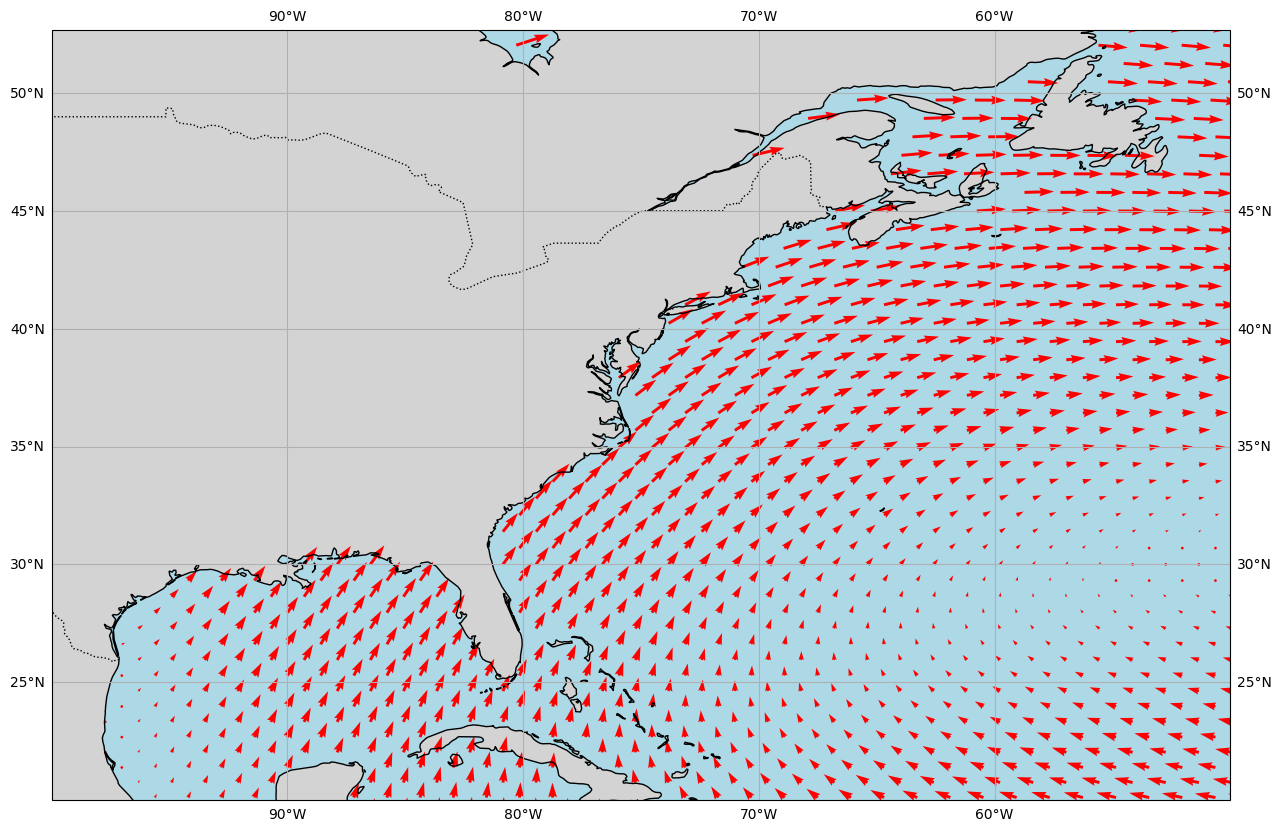

In [ ]:
grid_latitudes_extrapolarmask = (grid_latitudes > -60) & (grid_latitudes < 60)

In [147]:
grid_latitudes_extrapolarmask.any()

np.True_

In [152]:
time_centres

0   1981-09-03 12:00:00+00:00
1   1986-10-12 00:00:00+00:00
2   1991-11-19 00:00:00+00:00
3   1996-12-26 00:00:00+00:00
4   2002-02-02 00:00:00+00:00
5   2007-03-12 00:00:00+00:00
6   2012-04-18 00:00:00+00:00
7   2017-05-26 00:00:00+00:00
8   2022-07-03 00:00:00+00:00
dtype: datetime64[ns, UTC]

In [150]:
time_centres = (dts_intervals - dts_intervals.diff() / 2).iloc[1:].reset_index(drop=True)
estimated_mean_temp = np.zeros_like(time_centres)
for smoothed_data in [i for i in os.listdir() if "1000.csv" in i]:
    smoothed_data_df = pd.read_csv(smoothed_data)
    year0, year1, _ =  smoothed_data.split("_")


    idx = (time_centres - pd.Timestamp(f"{(int(year0) + int(year1)) // 2}-01-01", tz='utc')).abs().argmin()
    

    estimated_mean_temp[idx] = smoothed_data_df.Temperature[(grid_latitudes_extrapolarmask & mask)].mean()

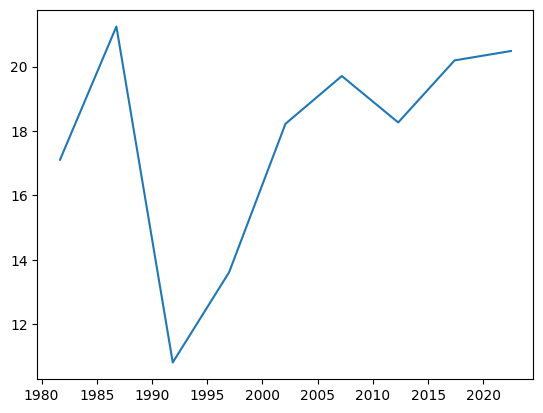

In [151]:
plt.plot(time_centres, estimated_mean_temp)

In [117]:
pd.Timestamp((float(year0) + float(year1)) / 2, tz='utc')

Timestamp('1970-01-01 00:00:00.000001986+0000', tz='UTC')

In [ ]:
r = np.corrcoef(time_centres.apply(lambda x: x.timestamp()).values, estimated_mean_temp)[0,1]
m = r * np.std(estimated_mean_temp) / np.std(time_centres) * 60 * 60 * 24 * 365.25



0    3.683664e+08
1    5.294592e+08
2    6.905088e+08
3    8.515584e+08
4    1.012608e+09
5    1.173658e+09
6    1.334707e+09
7    1.495757e+09
8    1.656806e+09
dtype: float64

In [ ]:
estimated_mean_temp

np.int64(1)

In [105]:
time_centres

array(['1981-09-03T12:00:00.000000000', '1986-10-12T00:00:00.000000000',
       '1991-11-19T00:00:00.000000000', '1996-12-26T00:00:00.000000000',
       '2002-02-02T00:00:00.000000000', '2007-03-12T00:00:00.000000000',
       '2012-04-18T00:00:00.000000000', '2017-05-26T00:00:00.000000000',
       '2022-07-03T00:00:00.000000000'], dtype='datetime64[ns]')